# 使用说明书
### 此代码实现的功能如下：
+ 读取data文件夹下所有的文件
+ 数据预处理：将Cal文件内数据读取并进行处理
+ 计算响应电阻、响应大小、区分度、响应稳定性、恢复程度、基线偏差
+ 从响应电阻、响应大小、区分度、响应稳定性、恢复程度、基线偏差对数据进行分组
+ 绘制响应电阻、响应大小、区分度 曲线图像
+ 筛选出满足6参数或是7参数的部件

---

### 注意事项：
1. ~~生成的报告文件批次目前仍然要手动填写~~
2. 测试的文件一定要先进行预处理，包括文件内容要包含0 200 100 80 50 51 53 0 或 0 80 50 51 53 0 ,否则要在ETH文件定位并抓取缺失点
3.  如因环境原因导致基线偏移需手动修改两个基线（在ETH文件抓取，第一基线和第二基线相差120行）
4. 目前仍未知空载位置是否会对分析结果造成影响（如良品率，测试总数）
5. 将cal文件放入data文件夹， ETH文件放入ETH_data文件夹
6. 一次只能处理同一批次的 ***测试文件*** 



```mermaid
操作流程
    [1]获取同一批次数据文件 
    --> [2]查看数据情况
    --> [3]有无测试点丢失点 
      --> [4_1]有 --> [5]抓取数据，在Cal文件里补充 --> [6]
      --> [4_2]无 --> [6]
    [6]将同一批次的Cal文件放到 data文件夹， 总数据文件（如ETH.txt）放到batch文件夹 
    --> [7]运行代码
    --> [8]在report文件夹查看报告
```


In [26]:
import matplotlib.pyplot as plt
import pandas as pd
import plotly.graph_objs as go
import numpy as np
import os
import math
import seaborn as sns
import re
from decimal import Decimal

读取文件内所有文件

In [27]:
def get_filepaths(dir):
    filepaths = []
    for filename in os.listdir(dir):
        filepath = os.path.join(dir, filename)
        if os.path.isfile(filepath):
            filepaths.append(filepath)
    return filepaths
 
filepaths = get_filepaths("data")
for i,j in enumerate(filepaths):
    filepaths[i]=j[5:]


data_total = pd.DataFrame(columns=[i for i in range(8)])
data_total.columns = columns=["0","20","10","5","2","2000","no","batch"]
for j,i in enumerate(filepaths):
        data = pd.read_csv("data/"+i,sep=r'\s+',names=[str(i) for i in range(2500)])
        data=data.transpose().dropna(how="all",axis=0)
        data = data[data.sum(axis=1) != 0][1:]
        data["no"] = data.index.values.astype(int)
        data["batch"]=filepaths[j][15:22]
        data.columns=["0","20","10","5","2","2000","no","batch"]
        data_total= pd.concat([data_total,data])

C:\Users\Administrator\AppData\Local\Temp\ipykernel_14516\3823409454.py:23: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  data_total= pd.concat([data_total,data])


In [28]:
# batch_name = filepaths[0][15:-4]
# pattern = r'\d+'
# numbers = re.findall(pattern, batch_name)
# batch_name=batch_name[:batch_name.find(numbers[2])-1]+"_"+batch_name[batch_name.find(numbers[3]):]

In [29]:
batch_name = filepaths[0][15:]
pattern = r'\d+'
numbers = re.findall(pattern, batch_name)
batch_name = filepaths[0][15:]
batch_name_1=""
batch_name_1+=batch_name[:batch_name.find(numbers[0])+numbers[0].__len__()]
batch_name=batch_name[batch_name.find(numbers[0])+numbers[0].__len__():]
batch_name_1+=batch_name[:batch_name.find(numbers[1])+numbers[1].__len__()]
batch_name_2=batch_name_1
batch_name=batch_name[batch_name.find(numbers[1])+numbers[1].__len__():]
batch_name=batch_name[batch_name.find(numbers[2])+numbers[2].__len__():]
total_num = sum([int(re.findall(pattern, i[15:])[3]) for i in filepaths])
batch_name_1+="_"+str(total_num)+batch_name[batch_name.find(numbers[3])+numbers[3].__len__():-4]
batch_name=batch_name_1

读取区间文件和计算指标


In [30]:
scale = pd.read_csv("scale_file_CH4.csv").T
scale.index=["response_resistance_x","response_size_x","discrimination_x","selectivity_x"]
response_resistance_x=list(scale[scale.index=="response_resistance_x"].T["response_resistance_x"])
response_size_x=list(scale[scale.index=="response_size_x"].T["response_size_x"])
discrimination_x=list(scale[scale.index=="discrimination_x"].T["discrimination_x"])
selectivity_x=list(scale[scale.index=="selectivity_x"].T["selectivity_x"])

response_resistance_x=[x for x in response_resistance_x if not math.isnan(x)]
response_size_x=[x for x in response_size_x if not math.isnan(x)]
discrimination_x=[x for x in discrimination_x if not math.isnan(x)]
selectivity_x=[x for x in selectivity_x if not math.isnan(x)]

In [31]:
response_resistance = data_total["10"]
response_size = data_total["0"]/data_total["10"]
discrimination = data_total["10"]/data_total["20"]
selectivity=(data_total["0"]/data_total["2"])-(data_total["0"]/data_total["2000"])

绘图

In [32]:
y_1=[0]+list(pd.cut(response_resistance,bins=response_resistance_x).value_counts(sort=False,normalize=True).values)
y_2=[0]+list(pd.cut(response_size,bins=response_size_x).value_counts(sort=False,normalize=True).values)
y_3=[0]+list(pd.cut(discrimination,bins=discrimination_x).value_counts(sort=False,normalize=True).values)
y_4=[0]+list(pd.cut(selectivity,bins=selectivity_x).value_counts(sort=False,normalize=True)[1:].values)

x_1=response_resistance_x[:-1]
x_1.append(5000)
x_2=response_size_x
x_3=discrimination_x
x_4=selectivity_x[1:]
x_1[-1]=">4800"

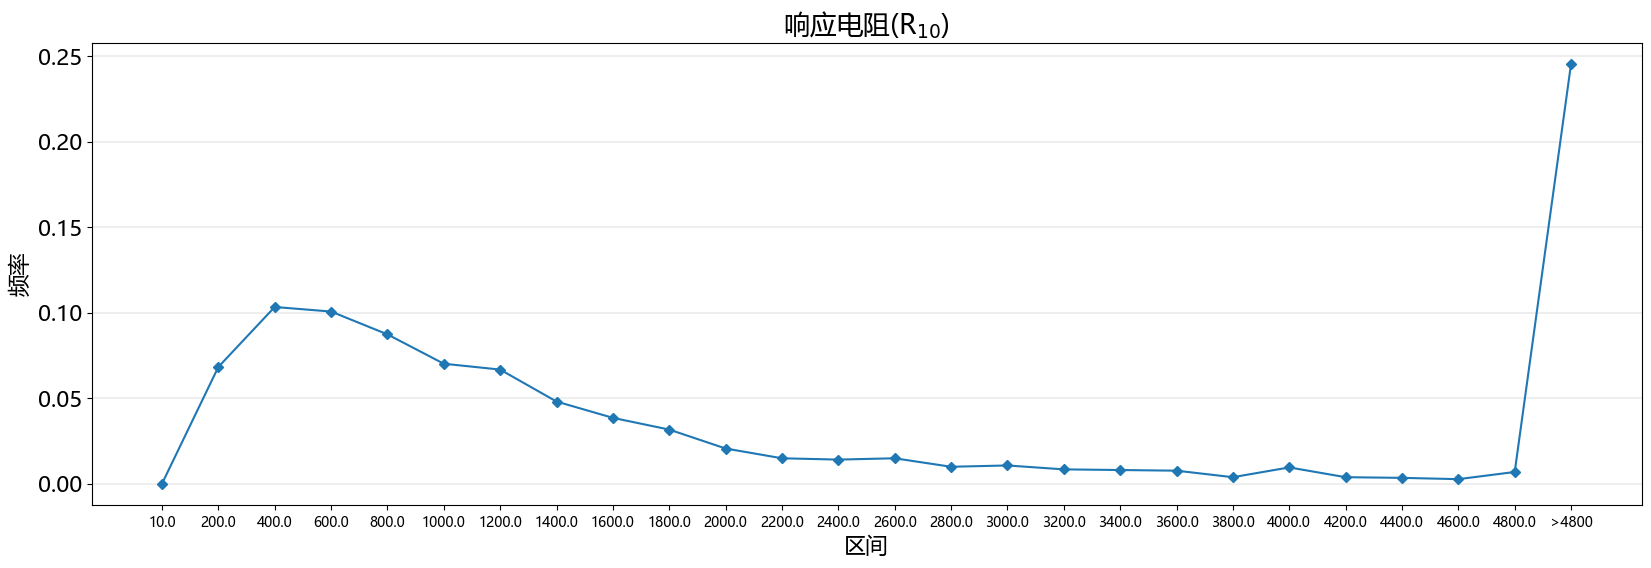

409600: 644


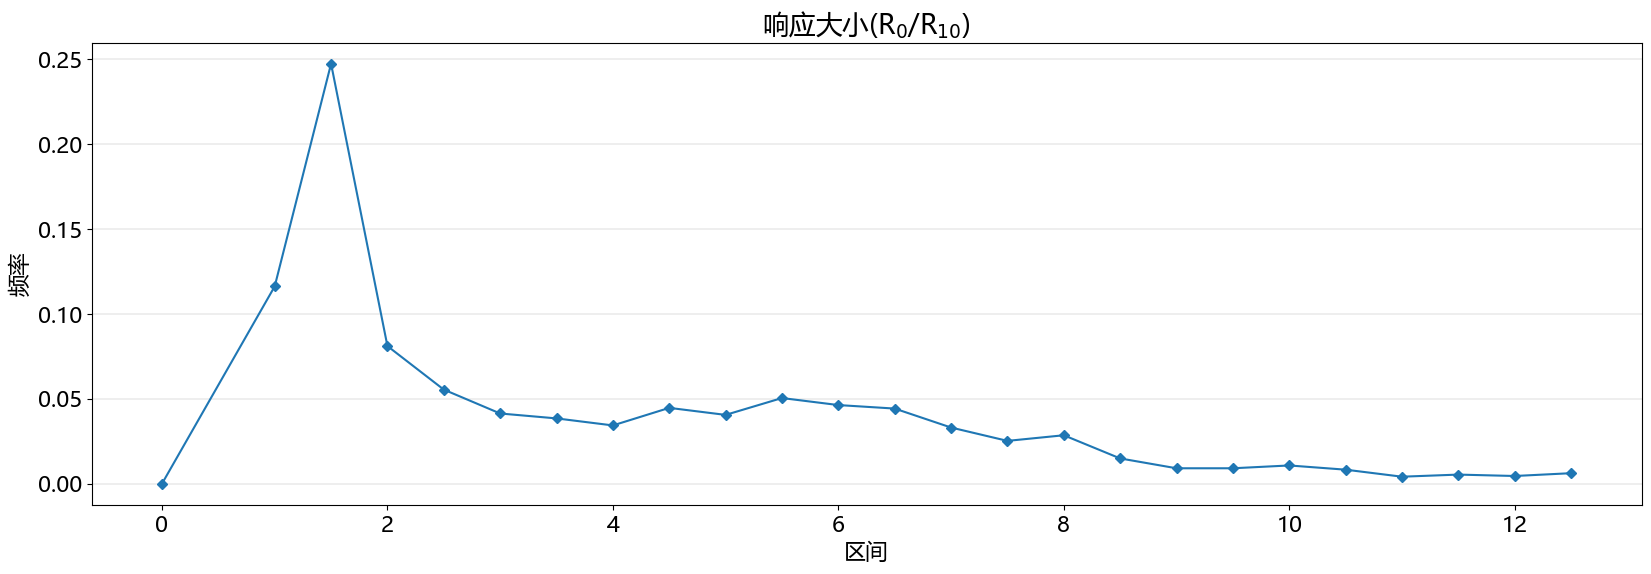

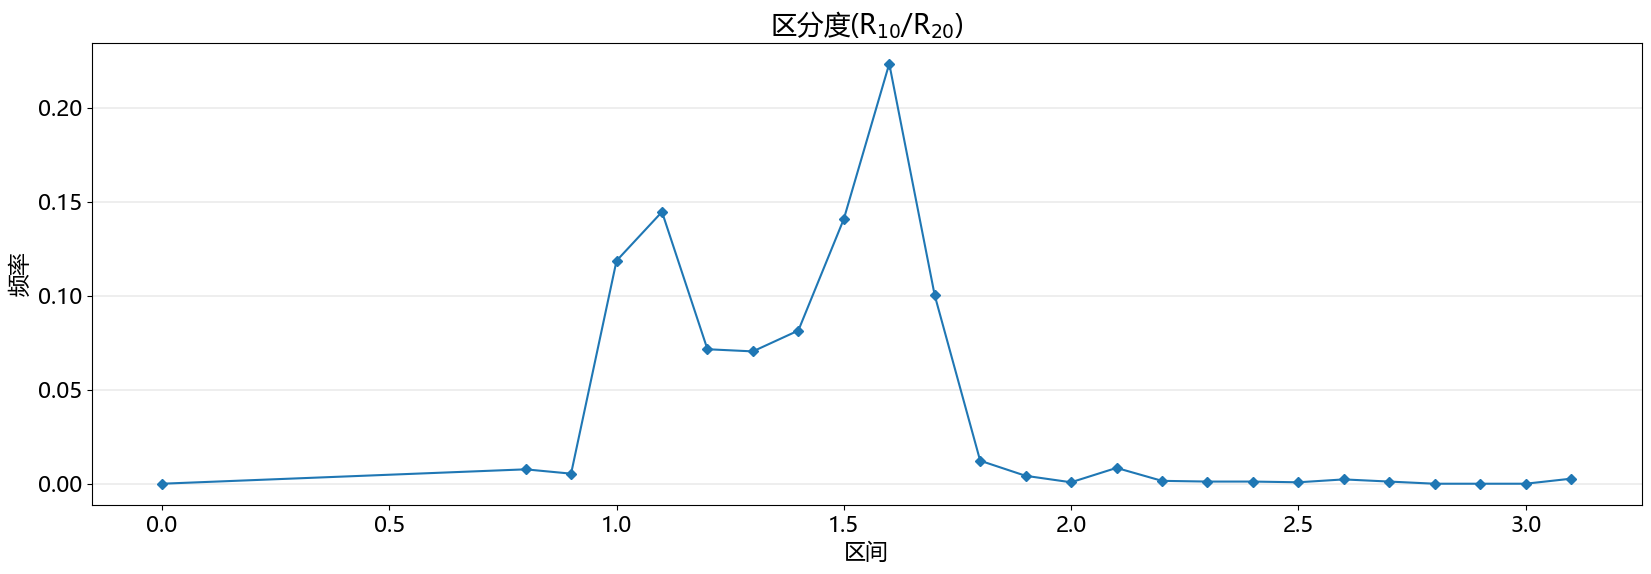

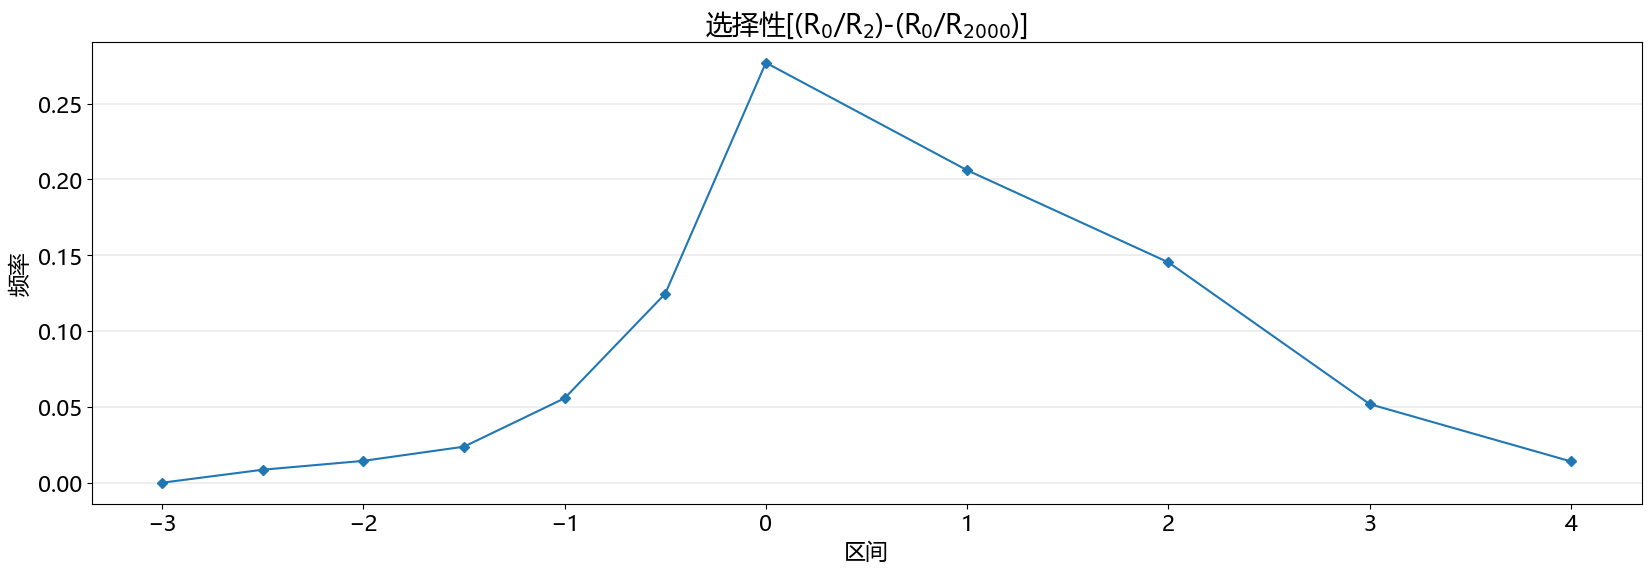

In [33]:
plt.rcParams['font.sans-serif'] = ['Microsoft YaHei'] 
plt.rcParams["font.size"] =16
plt.figure(figsize=(20, 6))
plt.title("响应电阻(R$_{10}$)")
plt.xlabel("区间")
plt.ylabel("频率")
plt.grid( axis='y', linewidth=0.3)
plt.xticks(fontsize=10)
plt.plot(x_1, y_1 ,marker='D', markersize=5)
plt.savefig('响应电阻.png')
plt.show()

print("409600:",pd.cut(response_resistance,bins=response_resistance_x).value_counts(sort=False).values[-1])

plt.figure(figsize=(20, 6))
plt.title("响应大小(R$_{0}$/R$_{10}$)")
plt.xlabel("区间")
plt.ylabel("频率")
plt.grid( axis='y', linewidth=0.3)
plt.plot(x_2, y_2, marker='D', markersize=5)
plt.savefig('响应大小.png')
plt.show()

plt.figure(figsize=(20, 6))
plt.title("区分度(R$_{10}$/R$_{20}$)")
plt.xlabel("区间")
plt.ylabel("频率")
plt.grid( axis='y', linewidth=0.3)
plt.plot(x_3, y_3, marker='D', markersize=5)
plt.savefig('区分度.png')
plt.show()

plt.figure(figsize=(20, 6))
plt.title("选择性[(R$_{0}$/R$_{2}$)-(R$_{0}$/R$_{2000}$)]")
plt.xlabel("区间")
plt.ylabel("频率")
plt.grid( axis='y', linewidth=0.3)
plt.plot(x_4, y_4, marker='D', markersize=5)
plt.savefig('选择性.png')
plt.show()

筛选

In [34]:
no_=data_total.index.values.astype(int)
data_processed = pd.concat(
        [pd.Series(no_,index=response_resistance.index),
        response_resistance,response_size,discrimination,selectivity,
        data_total["batch"]],axis=1)
columns=["序号","响应电阻",
    "响应大小",
    "区分度",
    "选择性",
    "部分"
    ]

data_processed.columns=columns

In [35]:
step_1=pd.merge(
    data_processed[data_processed["响应电阻"]>=10] , data_processed[data_processed["响应电阻"]<=1000],how="inner"
    )

step_2=step_1[step_1["响应大小"]>5]

step_3=step_2[step_2["区分度"]>1.2]
step_4=step_3[step_3["选择性"]>=0]


In [36]:
defective_products = []
defective_products.append(pd.merge(
    data_processed[data_processed["响应电阻"]>=10] , data_processed[data_processed["响应电阻"]<=1000],how="inner"
    ).__len__()/data_processed.__len__())
defective_products.append(data_processed[data_processed["响应大小"]>5].__len__()/data_processed.__len__())
defective_products.append(data_processed[data_processed["区分度"]>1.2].__len__()/data_processed.__len__())
defective_products.append(data_processed[data_processed["选择性"]>0].__len__()/data_processed.__len__())

In [37]:
step_4_=step_4.copy()
step_4_.index=step_4["序号"]
step_4_.index.name=''
merged_ = pd.concat([data_processed,step_4_])
merged=merged_.drop_duplicates(keep=False).copy()

In [38]:
defective_products_1 = []
defective_products_1.append(pd.concat(
    [merged[merged["响应电阻"]<10] , merged[merged["响应电阻"]>1000]]
    ).__len__()/merged.__len__())
defective_products_1.append((
    merged[merged["响应大小"]<=5]
    ).__len__()/merged.__len__())
defective_products_1.append((
    merged[merged["区分度"]<=1.2]
    ).__len__()/merged.__len__())
defective_products_1.append((
    merged[merged["选择性"]<=0]
    ).__len__()/merged.__len__())

In [39]:
defective_products_2 = []
defective_products_2.append(pd.concat(
    [merged[merged["响应电阻"]<10] , merged[merged["响应电阻"]>1000]]
    ).__len__())
defective_products_2.append((
    merged[merged["响应大小"]<=5]
    ).__len__())
defective_products_2.append((
    merged[merged["区分度"]<=1.2]
    ).__len__())
defective_products_2.append((
    merged[merged["选择性"]<=0]
    ).__len__())

In [40]:
defective_products_x=["不符合响应电阻","不符合响应大小","不符合区分度","不符合选择性"]
x_=[i for i in range(defective_products_1.__len__())]

In [41]:
[i for i in np.linspace(0,1,num=6)]

[0.0, 0.2, 0.4, 0.6000000000000001, 0.8, 1.0]

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


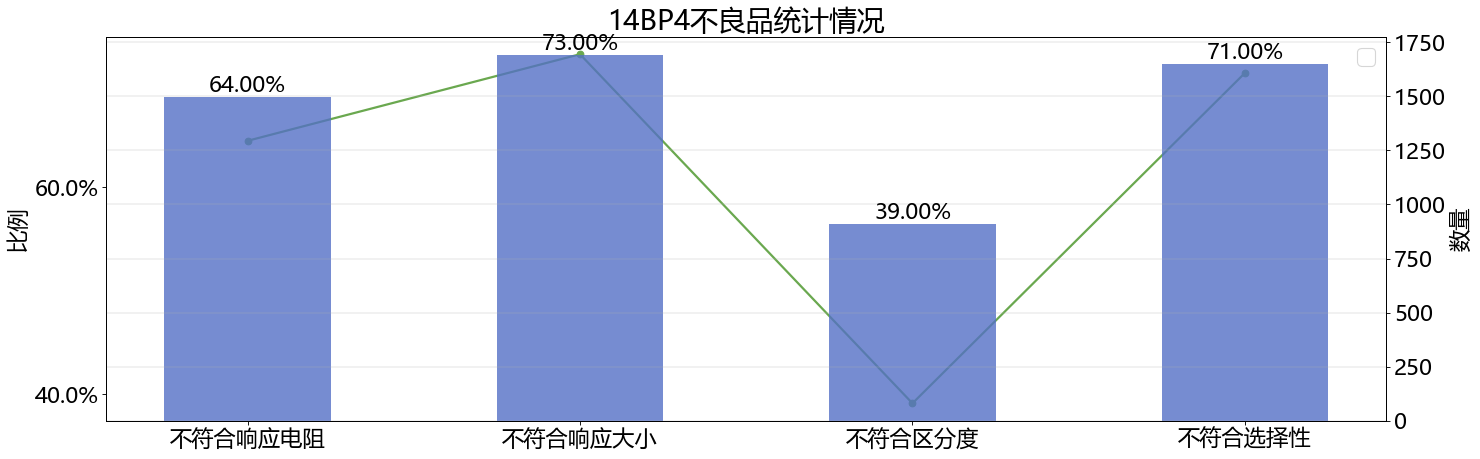

In [46]:
# sns.set()
plt.rcParams["font.size"] =20
plt.rcParams['font.sans-serif'] = ['Microsoft YaHei'] 
fig=plt.figure(figsize=(20, 6),dpi=80)
axis_1 = fig.add_axes((0.1, 0.1, 0.8, 0.8))
plt.yticks([i for i in np.linspace(0,1,num=6)],[str(round(i,1)*100)+"%"for i in np.linspace(0, 1, num=6)])
axis_2 = axis_1.twinx()
axis_1.plot(defective_products_x, defective_products_1, color="#6AA84F", marker="o", linewidth=2)
axis_1.set_ylabel("比例", size=20) 

axis_2.bar(defective_products_x,defective_products_2,width=0.5, alpha=0.8,color="#5470C6")
axis_2.set_ylabel("数量", size=20) 

plt.grid(True, linewidth=0.3)
for i in range(defective_products_1.__len__()):  
     plt.text(defective_products_x[i], defective_products_2[i], str(round(Decimal(defective_products_1[i]),2)*100)+"%", ha='center', va= 'bottom')

plt.title(batch_name_2+"不良品统计情况", size=25)
plt.legend()
plt.savefig("不良率.png")
plt.show()


In [43]:
filtered_no=[]
sc= list(step_4["部分"].values)
for j,i in enumerate(step_4["序号"]):
        if int(i)%64 == 0:
            filtered_no.append(str(int(i)//64-1)+"+"+str(64)+"+"+str(int(i)%64)+" "+sc[j])
        else:  filtered_no.append(str(int(i)//64)+"+"+str(int(i)%64)+" "+sc[j])

step_4["序号"]=filtered_no
step_4.to_excel("processed_CH4_total_"+batch_name+".xlsx")

C:\Users\Administrator\AppData\Local\Temp\ipykernel_14516\1982925519.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  step_4["序号"]=filtered_no


In [44]:
from docx import Document 
from docx.oxml.ns import qn
from docx.enum.text import WD_ALIGN_PARAGRAPH
from docx.enum.table import WD_ALIGN_VERTICAL
from docx.shared import Cm
from decimal import Decimal

document =Document()
document.styles['Normal'].font.name='楷体'
document.styles['Normal']._element.rPr.rFonts.set(qn('w:eastAsia'), '楷体')
run=document.add_heading('',level=0).add_run('分析报告')
run.font.name='微软雅黑'
_title = document.styles['Title']
_title.paragraph_format.alignment = WD_ALIGN_PARAGRAPH.CENTER
paragraph = document.add_paragraph('本次测试日期为'+filepaths[0][:filepaths[0].find("14")]) 
paragraph.paragraph_format.alignment = WD_ALIGN_PARAGRAPH.JUSTIFY
paragraph = document.add_paragraph('本次测试批次为：'+batch_name+'，一共测试'+str(total_num)+"个器件")

paragraph = document.add_paragraph('各参数筛选合格率') 
paragraph.paragraph_format.alignment = WD_ALIGN_PARAGRAPH.CENTER 
table = document.add_table(rows=1, cols=3, style='Table Grid') 
table.style.paragraph_format.alignment=WD_ALIGN_PARAGRAPH.CENTER
hdr_cells = table.rows[0].cells
hdr_cells[0].text = '指标名称'
hdr_cells[1].text = '值(良品率)'
hdr_cells[2].text = '值(不良率)'
table.cell(0,0).width=Cm(5) 
table.cell(0,1).width=Cm(10) 

mlst =["响应电阻",
    "响应大小",
    "区分度",
    "选择性",
    ]

for i,_row in enumerate(mlst):
    row_cells = table.add_row().cells # 添一行表格元素
    row_cells[0].text = _row
    row_cells[1].text = ' '+str(round(Decimal(defective_products[i]),2)*100)[:5]+"%"
    row_cells[2].text = ' '+str(round(Decimal(1-defective_products[i]),2)*100)[:5]+"%"
    p = row_cells[1].paragraphs[0]
    p.paragraph_format.alignment =WD_ALIGN_PARAGRAPH.JUSTIFY # 单元格文字两端对齐

paragraph = document.add_paragraph(' ')

paragraph = document.add_paragraph('参数筛选区间表') 
paragraph.paragraph_format.alignment = WD_ALIGN_PARAGRAPH.CENTER 
table = document.add_table(rows=1, cols=2, style='Table Grid') 
table.style.paragraph_format.alignment=WD_ALIGN_PARAGRAPH.CENTER
hdr_cells = table.rows[0].cells
hdr_cells[0].text = '指标名称'
hdr_cells[1].text = '区间范围'
table.cell(0,0).width=Cm(5) 
table.cell(0,1).width=Cm(10) 

mlst =["响应电阻",
    "响应大小",
    "区分度",
    "选择性",
    ]
sc=["10-1000",">5",">1.2",">0",]

for i,_row in enumerate(mlst):
    row_cells = table.add_row().cells 
    row_cells[0].text = _row
    row_cells[1].text = ' '+sc[i]
    p = row_cells[1].paragraphs[0]
    p.paragraph_format.alignment =WD_ALIGN_PARAGRAPH.JUSTIFY 

paragraph = document.add_paragraph(' ')

paragraph = document.add_paragraph('其中符合4参数器件'+str(step_4.__len__())+"个器件"+"，良品率(占测试总数量)为"+str(round(Decimal(step_4.__len__()/data_total.__len__()),4)*100)[:5]+"%")
paragraph = document.add_paragraph('其中符合4参数器件:'+str(list(step_4["序号"])))


document.add_picture('响应电阻.png', width=Cm(15))
document.add_picture('响应大小.png', width=Cm(15))
document.add_picture('区分度.png', width=Cm(15))
document.add_picture('选择性.png', width=Cm(15))
document.add_picture('不良率.png', width=Cm(15))

document.save('report/分析报告_'+batch_name+'.docx')
